# 3D Molchanov 2 - MLflow

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Load Data

In [2]:
from recognizer.utils.constants import ROOT_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

DATASET_DIR_POSTA = ROOT_DIR / "data" / "all-20percent"

In [3]:
import os

import pandas as pd

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR_POSTA):

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR_POSTA / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,001,001,001,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
1,001,001,002,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
2,001,001,003,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
3,001,001,004,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
4,001,001,005,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0


### Train/Test split

In [4]:
import numpy as np

size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

testing_set = metadata.groupby(["target", "subject"], as_index=False).apply(fn)

testing_set.index = testing_set.index.droplevel(0)

training_set = metadata.loc[~metadata.index.isin(testing_set.index), :]

### Pre-processing functions

In [5]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, T<frames>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, H<height>, W<width>, C<channels>) to (C<channels>, T<frames>, H<height>, W<width>)
    return x.permute(3, 0, 1, 2).float()


### Parameters

In [6]:
BATCH_SIZE = 24
NUM_CLASSES = 64
NUM_FRAMES = 16
EPOCHS = 50
LR = 0.05

In [7]:
from recognizer.dataset import SampledVideoDataset

training_dataset = SampledVideoDataset(
    video_filenames=training_set["file"].values,
    labels=training_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

testing_dataset = SampledVideoDataset(
    video_filenames=testing_set["file"].values,
    labels=testing_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

print(f"Training/testing set: ({len(training_dataset)}, {len(testing_dataset)})")

Training/testing set: (2560, 640)


In [8]:
testing_set.groupby("target_encoding").count()

,target,subject,repetition,file
target_encoding,,,,
0,10,10,10,10
1,10,10,10,10
2,10,10,10,10
3,10,10,10,10
4,10,10,10,10
...,...,...,...,...
59,10,10,10,10
60,10,10,10,10
61,10,10,10,10


In [9]:
UNIQUE_CLASSES = metadata.target_encoding.unique()

### Data Loaders

In [10]:
import torch 
from torch import nn

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device

'cuda'

### Model

In [12]:
from recognizer.models.molchanov_3d import Molchanov3DCNN

model = Molchanov3DCNN(
    num_classes=NUM_CLASSES,
    num_frames=NUM_FRAMES,
    batch_size=BATCH_SIZE,
)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_function = nn.CrossEntropyLoss()

In [13]:
from torchsummary import summary

summary(model, (3, 16, 216, 384), batch_size=24)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [24, 3, 12, 212, 380]           1,128
              ReLU-2      [24, 3, 12, 212, 380]               0
         MaxPool3d-3       [24, 3, 6, 106, 190]               0
            Conv3d-4       [24, 5, 4, 104, 188]             410
              ReLU-5       [24, 5, 4, 104, 188]               0
         MaxPool3d-6         [24, 5, 2, 52, 94]               0
            Linear-7                  [24, 100]       4,888,100
              ReLU-8                  [24, 100]               0
           Dropout-9                  [24, 100]               0
           Linear-10                   [24, 64]           6,464
Total params: 4,896,102
Trainable params: 4,896,102
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 364.50
Forward/backward pass size (MB): 1280.67
Params size (MB): 18.68
E

In [14]:
dummy_input = torch.randn(24, 3, 16, 216, 384).cuda()

output = model(dummy_input)

print("Output shape:", output.shape)  # Should be [24, 64]

Output shape: torch.Size([24, 64])


In [15]:
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {p}")

Params: 4896102


In [16]:
for n, p in model.named_parameters():
    print(f"Param: {n} | Shape: {p.shape}")

Param: conv_layer_1.0.weight | Shape: torch.Size([3, 3, 5, 5, 5])
Param: conv_layer_1.0.bias | Shape: torch.Size([3])
Param: conv_layer_2.0.weight | Shape: torch.Size([5, 3, 3, 3, 3])
Param: conv_layer_2.0.bias | Shape: torch.Size([5])
Param: fc_layer.0.weight | Shape: torch.Size([100, 48880])
Param: fc_layer.0.bias | Shape: torch.Size([100])
Param: fc_layer.3.weight | Shape: torch.Size([64, 100])
Param: fc_layer.3.bias | Shape: torch.Size([64])


## Set Up Experiment in MLflow

In [17]:
import mlflow
import os

from mlflow.entities import Experiment
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_SERVER_URI = "http://localhost:5001"

os.environ["AWS_ACCESS_KEY_ID"] = "miniouser"
os.environ["AWS_SECRET_ACCESS_KEY"] = "miniopass"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000/"

mlflow.set_tracking_uri(MLFLOW_TRACKING_SERVER_URI)
mlflow_client = MlflowClient(MLFLOW_TRACKING_SERVER_URI)

In [18]:
EXPERIMENT_NAME = "3D Molchanov 01"

experiment: Experiment = mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

In [19]:
RUN_NAME = "Execution 07"

run = None

matching_runs = mlflow_client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{RUN_NAME}'"
)

if len(matching_runs) > 0:
    raise Exception("Pisando run existente!!!!!")

run = mlflow_client.create_run(experiment_id=experiment.experiment_id)

mlflow_client.set_tag(run_id=run.info.run_id, key="mlflow.runName", value=RUN_NAME)

print(f"Run '{RUN_NAME}' creado con ID '{run.info.run_id}'")

Run 'Execution 07' creado con ID '9074f4a23f3640df856a97ba75d7130d'


### Log Params

In [20]:
mlflow_client.log_param(run_id=run.info.run_id, key="BATCH_SIZE", value=BATCH_SIZE)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_CLASSES", value=NUM_CLASSES)
mlflow_client.log_param(run_id=run.info.run_id, key="EPOCHS", value=EPOCHS)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_FRAMES", value=NUM_FRAMES)
mlflow_client.log_param(run_id=run.info.run_id, key="LR", value=LR)

print("Params successfully logged")

Params successfully logged


In [21]:
mlflow_client.log_text(run_id=run.info.run_id, text=str(testing_set.index.values), artifact_file="testing set index.txt")

INFO:botocore.credentials:Found credentials in environment variables.


## Training

In [22]:
import subprocess

CMD = '''
on run argv
  display notification (item 2 of argv) with title (item 1 of argv) sound name "Glass"
end run
'''

def notify(title, text):
    subprocess.call(['osascript', '-e', CMD, title, text])

In [23]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

cm = None

metrics = {
    "training_loss": [],
    "testing_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [24]:
print(
f"""
Beginning model training with parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
"""
)

best_loss = np.inf
patience = 5
delta = 0.01
epochs_without_improvement = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} - Training phase")

    model.train()

    running_training_loss = 0.0

    for _, data in enumerate(train_loader):

        batch, labels = data[0].to(device), data[1].to(device)

        logits = model(batch)

        loss = loss_function(logits, labels)

        running_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_training_loss = running_training_loss / len(train_loader)
    metrics["training_loss"].append(round(average_training_loss, 2))

    print(f"    - AVG Training Loss: {average_training_loss:.2f}")

    # Evaluation
    print(f"Epoch {epoch + 1} - Evaluation phase")

    model.eval()

    all_preds = []
    all_targets = []

    running_testing_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            logits = model(inputs)

            _, preds = torch.max(logits, 1)

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

            loss = loss_function(logits, labels)
            running_testing_loss += loss.item()

    average_testing_loss = running_testing_loss / len(test_loader)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    assert len(all_preds) == len(all_targets) == 640
    assert len(np.unique(all_targets)) == NUM_CLASSES

    unique_preds = set(all_preds.numpy())
    missing_classes = set(UNIQUE_CLASSES) - unique_preds

    if missing_classes:
        print(f"    The following classes ({len(missing_classes)}) were not predicted: {missing_classes}")

    metrics["testing_loss"].append(round(average_testing_loss, 2))
    metrics["accuracy"].append(accuracy_score(all_targets, all_preds))
    metrics["precision"].append(precision_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))
    metrics["recall"].append(recall_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))
    metrics["f1"].append(f1_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))

    for metric in metrics.keys():
        mlflow_client.log_metric(
            run_id=run.info.run_id,
            key=metric,
            value=metrics[metric][epoch],
            step=epoch,
        )
    
    print(f"""
    - Testing Loss: {metrics['testing_loss'][-1]}
    - Accuracy  : {metrics['accuracy'][-1]}
    - Precision : {metrics['precision'][-1]}
    - Recall    : {metrics['recall'][-1]}
    - F1        : {metrics['f1'][-1]}
    """)

    if average_testing_loss < best_loss - delta:
        best_loss = average_testing_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Testing loss is not improving!")
        break

    if epoch == EPOCHS - 1:
        cm = confusion_matrix(all_targets, all_preds)



Beginning model training with parameters:
- Epochs: 50
- Batch Size: 24

Epoch 1 - Training phase
    - AVG Training Loss: 13.63
Epoch 1 - Evaluation phase
    The following classes (63) were not predicted: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}

    - Testing Loss: 4.17
    - Accuracy  : 0.015625
    - Precision : 0.000244140625
    - Recall    : 0.015625
    - F1        : 0.0004807692307692308
    
Epoch 2 - Training phase
    - AVG Training Loss: 4.19
Epoch 2 - Evaluation phase
    The following classes (63) were not predicted: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}

    - Testing 

## Evaluation

### Confusion Matrix

In [25]:
cm = confusion_matrix(all_targets, all_preds)

<AxesSubplot: >

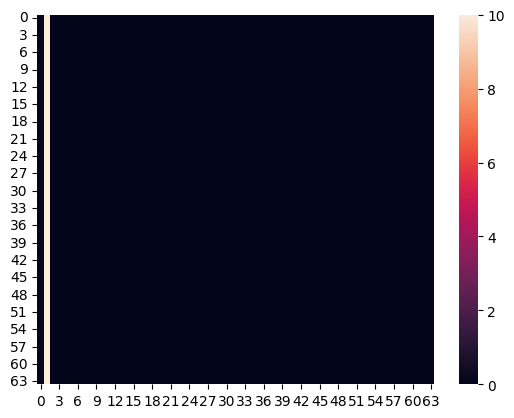

In [26]:
import seaborn as sns

sns.heatmap(data=cm)

### Accuracy/Recall/Precision

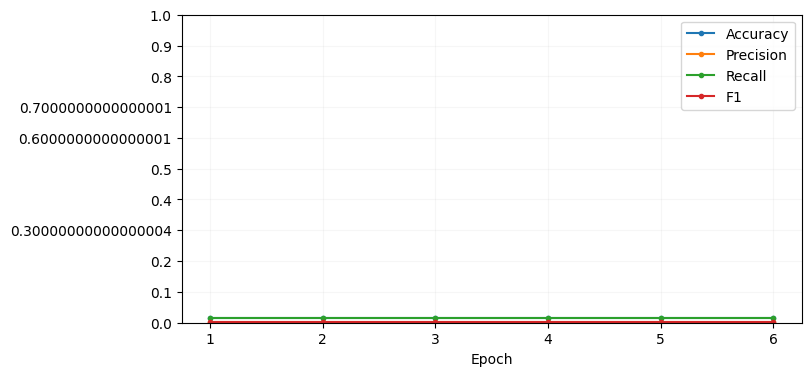

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["accuracy"], label="Accuracy", marker=".")
ax.plot(metrics["precision"], label="Precision", marker=".")
ax.plot(metrics["recall"], label="Recall", marker=".")
ax.plot(metrics["f1"], label="F1", marker=".")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

### Loss

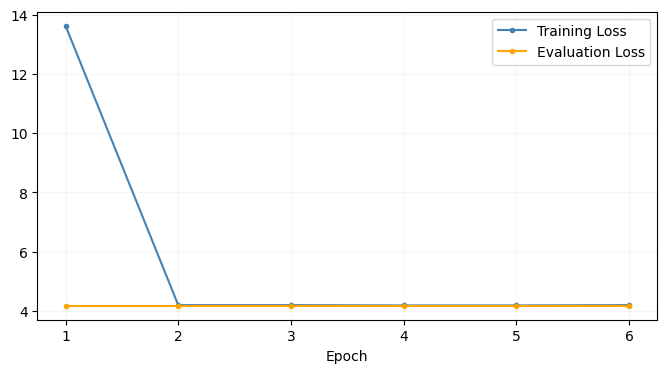

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["training_loss"], label="Training Loss", marker=".", color="steelblue")
ax.plot(metrics["testing_loss"], label="Evaluation Loss", marker=".", color="orange")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

## Save model

In [29]:
import copy
from recognizer.utils.constants import ROOT_DIR

MODELS_DIR = ROOT_DIR / "models"

MODEL_PATH = MODELS_DIR / f"{EXPERIMENT_NAME}_{RUN_NAME}.pth"

if MODEL_PATH.exists():
        raise Exception("El modelo ya existe!!!!")

with open(MODEL_PATH, "w") as f:
        f.write("")

torch.save(copy.deepcopy(model.state_dict()), f=MODEL_PATH)

In [30]:
mlflow_client.log_artifact(
    run_id=run.info.run_id,
    local_path=str(MODEL_PATH),
    artifact_path="",
)

In [31]:
import tempfile
import os

# Save the arrays to temporary npy files
with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as f:
    np.save(f, all_targets)
    ground_truth_path = f.name

    f.close()

    # Log the files to MLflow
    mlflow_client.log_artifact(
        run_id=run.info.run_id,
        local_path=ground_truth_path, 
        artifact_path="ground_truth"
    )


with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as f:
    np.save(f, all_preds)
    predictions_path = f.name

    f.close()

    mlflow_client.log_artifact(
        run_id=run.info.run_id,
        local_path=predictions_path, 
        artifact_path="predictions"
    )

In [32]:
mlflow.end_run()

## Clasificación manual

In [33]:
import random

idx = random.randint(0, BATCH_SIZE-1)

batch, klasses = next(iter(test_loader))

sign_video = batch[idx]

klass = klasses[idx]

In [34]:
sign_video = sign_video.unsqueeze(0)
sign_video.shape

torch.Size([1, 3, 16, 216, 384])

In [35]:
model.eval()

logits = model(sign_video.to(device))

In [36]:
logits

tensor([[-0.1570,  0.2251, -0.0381, -0.0514, -0.2135, -0.0953, -0.0632, -0.0746,
          0.0566,  0.0246, -0.2652,  0.0856, -0.0147, -0.3748,  0.0701, -0.1937,
          0.0610, -0.1365, -0.2044, -0.0657, -0.1983,  0.0648, -0.0824, -0.1228,
         -0.1120,  0.1527, -0.0585,  0.1006, -0.2217,  0.0229, -0.1193, -0.1292,
         -0.0067, -0.2769, -0.1482, -0.2373, -0.1272,  0.0137, -0.2064, -0.1167,
         -0.0891,  0.0170,  0.1781,  0.1967, -0.3095,  0.1569, -0.0084, -0.0119,
          0.0130, -0.1071,  0.0801,  0.1719,  0.1608,  0.0930,  0.0095,  0.2214,
          0.0608, -0.1734, -0.2331, -0.1308, -0.0899, -0.1657, -0.0370, -0.0181]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [37]:
from torch import nn

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Ground Truth: {klass}. Predicted class: {y_pred}")

Ground Truth: 1. Predicted class: tensor([1], device='cuda:0')


In [38]:
raise Exception("No pasar de acá")

Exception: No pasar de acá

## Loading the model

In [ ]:
def load_state_dict(run_id: str, model_path: str):
    return mlflow_client.download_artifacts(
        run_id=run_id,
        path=model_path,
    )

In [ ]:
state_dict_path = load_state_dict(run_id=run.info.run_id, model_path=f"{EXPERIMENT_NAME}_{RUN_NAME}.pth")

loaded_model = Molchanov3DCNN(num_classes=NUM_CLASSES, num_frames=NUM_FRAMES, batch_size=BATCH_SIZE).load_state_dict(torch.load(state_dict_path))

loaded_model

## Load testing index

In [ ]:
def load_testing_set_index(run_id: str):
    local_path = mlflow_client.download_artifacts(
        run_id=run_id,
        path="testing set index.txt",
    )

    with open(local_path, encoding="utf-8") as f:
        return f. read()

In [ ]:
import re

test_idx_str = load_testing_set_index(
    run_id=run.info.run_id,
)

test_idx = [int(x) for x in re.findall(r'\d+', test_idx_str)]

assert len(test_idx) == 640

In [ ]:
loaded_test_set = metadata.loc[test_idx]

loaded_test_set.groupby("target")["subject"].count()

In [ ]:
testing_dataset = SampledVideoDataset(
    video_filenames=loaded_test_set["file"].values,
    labels=loaded_test_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

## Make inferences

In [ ]:
model.eval()

all_preds = []
all_targets = []

running_testing_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        logits = model(inputs)

        _, preds = torch.max(logits, 1)

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

        loss = loss_function(logits, labels)
        running_testing_loss += loss.item()

average_testing_loss = running_testing_loss / len(test_loader)

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

assert len(all_preds) == len(all_targets) == 640
assert len(np.unique(all_targets)) == NUM_CLASSES

## Loading labels and preds

In [ ]:
import os
from pathlib import Path
from typing import Literal


def load_preds_or_labels(run_id: str, artifact: Literal["predictions", "ground_truth"]) -> np.ndarray:
    ret_val = None
    artifact_path = mlflow_client.download_artifacts(
        run_id=run_id,
        path=artifact,
    )

    for f in os.listdir(artifact_path):
        data = np.load(Path(artifact_path) / f)
        ret_val = np.concatenate([ret_val, data]) if ret_val is not None else data

    return ret_val

In [ ]:
loaded_preds = None
loaded_labels = None

loaded_preds = load_preds_or_labels(run_id=run.info.run_id, artifact="predictions")
loaded_labels = load_preds_or_labels(run_id=run.info.run_id, artifact="ground_truth")

loaded_preds.shape, loaded_labels.shape

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

accuracy_score(loaded_labels, loaded_preds)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# Initialize the LabelBinarizer
lb = LabelBinarizer()

# Fit and transform y_true to get the 2D array with one-hot encoding
y_true_one_hot = lb.fit_transform(loaded_labels)
y_score_one_hot = lb.fit_transform(loaded_preds)

y_true_one_hot.shape, y_score_one_hot.shape

In [ ]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

roc_auc_macro_ovr = roc_auc_score(y_true=y_true_one_hot, y_score=y_score_one_hot, average="macro", multi_class="ovr")

roc_auc_macro_ovr

In [ ]:
cm2 = confusion_matrix(loaded_labels, loaded_preds)

In [ ]:
ENCODING_TO_TARGET: dict[int, str] = {v: k for k, v in TARGET_TO_ENCODING.items()}

In [ ]:
x_axis_labels = TARGET_TO_ENCODING

In [ ]:
import seaborn as sns

from recognizer.utils.constants import TARGET_TO_WORD

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 18), dpi=150, facecolor="white")

heatmap = sns.heatmap(data=cm2, ax=ax, annot=True, cmap="crest")

x_ticks = [int(label.get_text()) for label in heatmap.get_xticklabels()]
y_ticks = [int(label.get_text()) for label in heatmap.get_yticklabels()]

x_new_labels = [TARGET_TO_WORD[ENCODING_TO_TARGET[x]] for x in x_ticks]
y_new_labels = [TARGET_TO_WORD[ENCODING_TO_TARGET[y]] for y in y_ticks]

heatmap.set_xticklabels(x_new_labels)
heatmap.set_yticklabels(y_new_labels)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()
